Capstone Project: Build a live camera app
=============


3. Implementation
------------

- 3.1 Import modules and data
- 3.2 Create helper functions
- 3.3 Set up the model
- 3.4 Run the model with different hyperparameters
- 3.5 Compare performance

**3.1 Import modules and data**

Get the modules and load the data from the pickle.

In [1]:
from __future__ import print_function
from __future__ import division

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
import random

import os
from six.moves import cPickle as pickle

from timeit import default_timer as timer
from time import gmtime, strftime
import time

In [2]:
def load_from_pickle(pickle_file):
  with open(pickle_file, 'rb') as f:
    data = pickle.load(f)
  print('Data loaded from %s.' % pickle_file)
  return data

train_dataset, train_labels = load_from_pickle('train_data_preprocessed.pickle')
test_dataset,  test_labels  = load_from_pickle('test_data_preprocessed.pickle')

print('Train data', train_dataset.shape, train_dataset.dtype)
print('Train labels', train_labels.shape, train_labels.dtype)
print('Test data',  test_dataset.shape, test_dataset.dtype)
print('Test labels', test_labels.shape, test_labels.dtype)

Data loaded from train_data_preprocessed.pickle.
Data loaded from test_data_preprocessed.pickle.
Train data (33402, 64, 64) float32
Train labels (33402, 7) float64
Test data (13068, 64, 64) float32
Test labels (13068, 7) float64


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
# Define global constants
IMAGE_SIZE      = 64
NUM_LABELS      = 11   # the logical size of the one-hots 
NUM_CLASSIFIERS =  5   # the number of softmax classifiers we'll create
ONE_HOT_SIZE    = 10   # in practice we'll just create one big array of one-hots this size
NUM_CHANNELS    =  1   # grayscale

def reformat(dataset, labels):
  # reshape dataset to have the pixel value in an array size 1, for the convolutions 
  dataset = dataset.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)
  print('Data', dataset.shape, dataset.dtype)
  # reshape the labels to ignore the length, just include the digits, keeping the value 0 as "no digit"  
  labels  = labels[:, 1:NUM_CLASSIFIERS+1].astype(np.int64)
  print('Labels', labels.shape, labels.dtype)
  print(np.array([np.histogram(label_i, bins=range(11))[0] for label_i in np.transpose(labels)], dtype='int'))
  return dataset, labels

print('Train data:')
train_dataset, train_labels = reformat(train_dataset, train_labels)
print('Test data:')
test_dataset, test_labels = reformat(test_dataset, test_labels)

Train data:
Data (33402, 64, 64, 1) float32
Labels (33402, 5) int64
[[    0  9243  6321  4348  3511  2829  2153  1877  1585  1535]
 [ 5137  3332  3131  2970  2807  2870  2489  2640  2379  5647]
 [23267  1128   983  1057   979  1047   955   961   940  2085]
 [31958   156   150   120   161   134   130   115   140   338]
 [33392     2     0     2     0     2     0     2     0     2]]
Test data:
Data (13068, 64, 64, 1) float32
Labels (13068, 5) int64
[[    0  3694  2657  1625  1236  1052   857   747   625   575]
 [ 2483  1144  1233  1027  1080  1078   921  1020   835  2247]
 [10839   244   243   217   198   242   182   239   192   472]
 [12920    17    16    13     9    12    17    12     8    44]
 [13066     0     0     0     0     0     0     1     0     1]]


**3.2 Create helper functions**

First define the low level functions to create components of layers.

In [ ]:
def create_placeholders():
  input_data = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), name='Input/Data')
  labels     = tf.placeholder(tf.int64, shape=(None, NUM_CLASSIFIERS), name='Input/Labels')
  keep_prob  = tf.placeholder(tf.float32, name='Dropout_keep_prob')
  tf.scalar_summary('Parameters/Dropout (keep)',keep_prob)
  return input_data, labels, keep_prob

def add_variable_summaries(variable, name): # To analyse all variables in tensorboard
  if TENSORBOARD_SHOW_ALL:
    with tf.name_scope('Summaries'):
      tf.scalar_summary(name+'/min', tf.reduce_min(variable))
      tf.scalar_summary(name+'/max', tf.reduce_max(variable))
      mean = tf.reduce_mean(variable) # put it in a variable as we use it twice
      with tf.name_scope('Std_dev'):
        std_dev = tf.sqrt(tf.reduce_mean(tf.square(variable - mean)))
      tf.scalar_summary(name+'/mean', mean)
      tf.scalar_summary(name+'/std_dev', std_dev)
      tf.histogram_summary(name, variable)

def create_weights(layer_name, dimensions):
  with tf.name_scope('Weights'):
    input_dims = np.prod(dimensions[:-1])   # the last element is the output dimension, all others inputs
    init_stddev = np.sqrt(2.0 / input_dims) # this ensures the variance after ReLU is 1
    weights = tf.Variable(tf.truncated_normal(dimensions,stddev = init_stddev))
    add_variable_summaries(weights, layer_name+'/weights')
  return weights

def create_biases(layer_name, output_dim):
  with tf.name_scope('Biases'):
    biases  = tf.Variable(tf.zeros([output_dim])) # initialise to zero
    add_variable_summaries(biases, layer_name+'/biases')
  return biases

def create_activations(layer_name, pre_activations, activation_func):
  with tf.name_scope('Activations'):
    activations = activation_func(pre_activations)
    tf.histogram_summary(layer_name+'/2_activations', activations)
  return activations

def add_l2_losses(layer_name, l2_loss_list, weights, biases):
  with tf.name_scope('L2_losses'):
    l2_losses = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    tf.scalar_summary(layer_name+'/L2_losses',l2_losses)
    l2_loss_list.append(l2_losses)
    return l2_loss_list

Now define the functions to build the layers.

In [ ]:
def create_conv_layer(layer_name, input_tensor, l2_loss_in, patch_size, out_channels, stride, 
                      max_pool_kernel, max_pool_stride, activation_func):
  in_channels = input_tensor.get_shape().as_list()[3]
  with tf.name_scope(layer_name):
    weights = create_weights(layer_name, [patch_size, patch_size, in_channels, out_channels])
    biases  = create_biases(layer_name, out_channels)
    with tf.name_scope('Convolutions'):
      strides = [1, stride, stride, 1]
      convolutions = tf.nn.conv2d(input_tensor, weights, strides, padding="SAME")
      tf.histogram_summary(layer_name+'/1_convolutions', convolutions)
    with tf.name_scope('Max_pooling'):
      if max_pool_stride > 1:
        ksize   = [1, max_pool_kernel, max_pool_kernel, 1]
        strides = [1, max_pool_stride, max_pool_stride, 1]
        convolutions = tf.nn.max_pool(convolutions, ksize, strides, padding="SAME")
    activations = create_activations(layer_name, convolutions + biases, activation_func)
    l2_loss_out = add_l2_losses(layer_name, l2_loss_in, weights, biases)
  return activations, l2_loss_out

def create_all_conv_layers(next_input, l2_loss, conv_layers, keep_prob):
  for i, conv_layer in enumerate(conv_layers):
    patch_size, depth, stride, mp_kernel, mp_stride = conv_layer
    next_input, l2_loss = create_conv_layer('Convolution'+str(i+1), next_input, l2_loss, 
                                            patch_size, depth, stride, mp_kernel, mp_stride, tf.nn.relu) 
    next_input = tf.nn.dropout(next_input, keep_prob, name='Dropout')
  return next_input, l2_loss

def flatten_conv_to_fc(next_input):
  with tf.name_scope('Flatten'):
    shape      = next_input.get_shape().as_list()
    next_input = tf.reshape(next_input, [-1,shape[1]*shape[2]*shape[3]])
  return next_input

def create_fully_connected_layer(layer_name, input_tensor, l2_loss, input_dim, output_dim, activation_func):
  with tf.name_scope(layer_name):
    weights = create_weights(layer_name, [input_dim, output_dim])
    biases  = create_biases(layer_name, output_dim)
    with tf.name_scope('XW_plus_b'):
      pre_activations = tf.matmul(input_tensor, weights) + biases
      tf.histogram_summary(layer_name+'/1_pre_activations', pre_activations)
    activations = create_activations(layer_name, pre_activations, activation_func)
    l2_loss = add_l2_losses(layer_name, l2_loss, weights, biases)
  return activations, l2_loss

def create_all_fc_layers(next_input, l2_loss, fc_layers, keep_prob):
  fc_layer_count = len(fc_layers)
  input_dims     = next_input.get_shape().as_list()[1]
  fc_node_counts = [input_dims] + fc_layers
  for i in range(fc_layer_count):
    next_input, l2_loss = create_fully_connected_layer('Fully_Connected'+str(i+1), next_input, l2_loss,
                                                       fc_node_counts[i],fc_node_counts[i+1],
                                                       tf.nn.relu if i+1 < fc_layer_count else tf.identity) 
    next_input = tf.nn.dropout(next_input, keep_prob, name='Dropout') if i+1 < fc_layer_count else next_input
  return next_input, l2_loss 

def create_logits_for_all_outputs(features, l2_loss):
  input_dim = features.get_shape().as_list()[1]
  logits_list = []
  for i in range(NUM_CLASSIFIERS):
    layer_name = 'Digit_'+str(i+1)
    logits, l2_loss = create_fully_connected_layer(layer_name, features, l2_loss, input_dim, NUM_LABELS, tf.identity)
    logits_list.append(logits)
  return logits_list, l2_loss

And finally, define the functions to calculate loss and accuracy, create the training step, and any helper functions to run the model.

In [ ]:
def calculate_loss(logits_list, labels, l2_loss_list, weight_decay, batch_size):
  with tf.name_scope('Loss'):
    with tf.name_scope('Cross_entropy'):
      cross_entropy_total = 0.0
      cross_entropy_list = []
      labels_list = tf.unpack(labels, axis=1) # unpack to have one loss object per classifier in the graph
      for i in range(NUM_CLASSIFIERS):
        name            = 'Digit_'+str(i+1)
        cross_entropies = tf.nn.sparse_softmax_cross_entropy_with_logits(logits_list[i], labels_list[i])
        cross_entropy_list.append(cross_entropies)
        cross_entropy   = tf.reduce_mean(cross_entropies, name=name)
        tf.scalar_summary('Loss/Cross_entropy/'+name,cross_entropy)
        cross_entropy_total += cross_entropy
      tf.scalar_summary('Loss/Cross_entropy/Total',cross_entropy)
    with tf.name_scope('L2_loss'):
      l2_loss = tf.add_n(l2_loss_list)
      l2_loss_component = weight_decay * batch_size / TRAIN_SIZE * l2_loss
      tf.scalar_summary('Parameters/Weight_decay',weight_decay)
      tf.scalar_summary('Loss/L2_loss_component',l2_loss_component)
    loss = cross_entropy_total + l2_loss_component
    tf.scalar_summary('Loss/Total',loss)
  return loss, cross_entropy_list

def calculate_accuracy(logits_list, labels):
  with tf.name_scope('Accuracy'):
    with tf.name_scope('Predictions'):
      logits_array = tf.pack(logits_list, axis=1) # put the logits into a big array: [samples, classifiers, labels]
      predictions  = tf.argmax(logits_array, 2)   # find the label with the highest logit (softmax is monotonic)
    with tf.name_scope('Accuracy'):
      correct_predictions = tf.reduce_all(tf.equal(predictions, labels),1) # a sample is correct if all classifiers are correct    
      accuracy            = 100.0 * tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    tf.scalar_summary('Accuracy',accuracy)
  return accuracy

def create_training_step(loss, initial_rate, learn_decay_steps, learn_decay_rate, momentum, global_step):
  with tf.name_scope('Train'):
    with tf.name_scope('Learning_rate'):
      learning_rate = tf.train.exponential_decay(initial_rate, global_step, learn_decay_steps, learn_decay_rate)
      tf.scalar_summary('Parameters/Learning rate',learning_rate)
    if momentum is None: 
      train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    elif momentum  == "Adam": 
      train_step = tf.train.AdamOptimizer().minimize(loss, global_step=global_step)
    else: 
      train_step = tf.train.MomentumOptimizer(learning_rate,momentum).minimize(loss, global_step=global_step)
  return train_step

def get_next_batch(step, batch_size, train_dataset, train_labels):
  offset = (step * batch_size) % (TRAIN_SIZE - batch_size) 
  batch_data   = train_dataset[offset:(offset + batch_size), :, :, :]
  batch_labels =  train_labels[offset:(offset + batch_size), :]
  return batch_data, batch_labels

**3.3 Set up the model **

Using the helper functions, create the graph according to the specified design and regularisation hyperparameters. Then create the loop to run it according to the specified batch size, iterations and logging parameters.

In [ ]:
def define_and_run_model(data, params, log_params):
  # unpack the arguments
  train_dataset, train_labels, test_dataset, test_labels      = data
  num_steps, batch_size, conv_layers, fc_layers,\
    initial_rate, learn_decay_rate, learn_decay_steps, \
    weight_decay, momentum, dropout, nickname                 = params
  log_dir, log_printouts, tb_printouts, tb_all, progress_dots = log_params

  # set up constants
  global TRAIN_SIZE, IMAGE_SIZE, NUM_CHANNELS, NUM_LABELS, NUM_CLASSIFIERS, TENSORBOARD_SHOW_ALL
  TENSORBOARD_SHOW_ALL = tb_all
  TRAIN_SIZE = train_dataset.shape[0]
  graph = tf.Graph()

  # define the graph
  with graph.as_default():
   
    # create placeholders and variables
    input_data, labels, keep_prob = create_placeholders()
    global_step = tf.Variable(0, trainable=False, name='Global_step')

    # build the network
    next_input,  l2_loss = input_data, []
    next_input,  l2_loss = create_all_conv_layers(next_input, l2_loss, conv_layers, keep_prob)
    next_input           = flatten_conv_to_fc(next_input)
    features,    l2_loss = create_all_fc_layers(next_input, l2_loss, fc_layers, keep_prob)
    logits_list, l2_loss = create_logits_for_all_outputs(features, l2_loss)
    
    # calculate loss and accuracy; set up the training step
    loss, loss_list = calculate_loss(logits_list, labels, l2_loss, weight_decay, batch_size)
    accuracy        = calculate_accuracy(logits_list, labels)
    train_step      = create_training_step(loss, initial_rate, learn_decay_steps, learn_decay_rate, momentum, global_step)

    # bring together the summaries, create writers for them
    merged = tf.merge_all_summaries()

  # now run the graph
  with tf.Session(graph=graph) as sess:

    # initialise the summary writers
    train_writer = tf.train.SummaryWriter(log_dir+'/train', graph)
    test_writer  = tf.train.SummaryWriter(log_dir+'/test')

    # initialise log and timer for the homemade plotter
    learning_log = np.array([]).reshape(0,5) # the array we'll use to plot the learning curve
    start = timer()

    # the test feed dictionary doesn't change so define it now
    test_feed_dict = {input_data : test_dataset, labels : test_labels, keep_prob : 1.0}
  
    tf.initialize_all_variables().run()

    for step in range(num_steps):

      # define the feed dictionary for the training run - this happens every step
      batch_data, batch_labels = get_next_batch(step, batch_size, train_dataset, train_labels)
      train_feed_dict = {input_data : batch_data, labels : batch_labels, keep_prob : dropout}

      # sometimes we'll calculate test accuracy and save to tensorboard
      if step % (num_steps // tb_printouts) == 0 :
        _, train_loss, train_acc, train_summary = sess.run([train_step, loss, accuracy, merged], feed_dict=train_feed_dict)
        test_loss,      test_acc,  test_summary = sess.run([            loss, accuracy, merged], feed_dict=test_feed_dict)
        train_writer.add_summary(train_summary, step)
        test_writer.add_summary(test_summary, step)

      # sometime we'll just calculate test accuracy for the homemade plotter
      elif step % (num_steps // log_printouts) == 0 :
        _, train_loss, train_acc = sess.run([train_step, loss, accuracy], feed_dict=train_feed_dict)
        test_loss, test_acc      = sess.run([            loss, accuracy], feed_dict=test_feed_dict)

      # and otherwise, we just train the network
      else:
        sess.run([train_step], feed_dict=train_feed_dict)

      if step % (num_steps // log_printouts) == 0 :
        learning_log = np.append(learning_log, [[step, train_loss, test_loss, train_acc, test_acc]], axis=0)

      if step % (num_steps // progress_dots) == 0 : print(".",end="")

    # Finally, close the writers,  calculate accuracy on the test data:
    train_writer.close()
    test_writer.close()
    test_accuracy, test_logits, test_losses  = sess.run([accuracy, logits_list, loss_list], feed_dict=test_feed_dict)
    
    run_time = timer() - start
 
  return (test_logits, test_losses, learning_log, run_time, test_accuracy)  # for debugging
#  return learning_log, time_taken, test_acc

**3.4 Run the model with different hyperparameters**

First, set up any helper functions for the logging, and load the saved results log and set.

In [ ]:
def run_text_long(params, run_counter, test_accuracy, run_time):
  run_description = ("{:>5d}x{:>2d}, {:>23}, {:>5}, {:>4} rt,{:>4} dcy,{:>4} st, "
                     "W_d {:>4}, mmtm {:>4}, d_o {:>3.1f}".format(*params))
  text  = ("{:>2d}: {} - {:>4.1f}% acc in {:>4.0f}m".format(run_counter, run_description, test_accuracy, run_time/60))
  return text

def run_text_short(results):
  i, params, run_text, learning_log, test_accuracy, run_time = results
  text = ("{:>2d}: {:<20} - {:>4.1f}% acc in {:>4.0f}m".format(
                i, params[-1], test_accuracy, run_time/60))
  return text

def init_results_log(filename):
  if os.path.exists(filename):
    with open(filename, 'rb') as f:
      results_log = pickle.load(f)
    run_counter = len(results_log) 
    print('Results log loaded from {}'.format(filename))
  else:
    results_log, run_counter = [],0
    print('Results log initialised')
  return results_log, run_counter

if 'results_log' not in locals():
  results_log, run_counter = init_results_log("results.pickle")

Now specify a list of hyperparameter combinations and run the model on those, logging performance each time.

In [80]:
######################################### Set the hyperparameters to test #########################################
# conv_layer = patch_size, depth, stride, mp_kernel, mp_stride
# 0 steps, 1 batch, 2 convolution_layers,       3 fc_layers, 4 learn_rate, 5 ldecay_rate, 6 ldecay_steps, 
#   7 weight_decay, 8 learner, 9 dropout, 10 Nickname
param_list = [\
(   1001,   128,   [(5,16,2,2,2), (5,32,2,2,2)],  [1024],         0.05,           1.0,              1,   \
               0.0,    None,       1.0, "1000 runs with logits for debugging")]
# (  501,  32,        [(5,16,2,1,1)],     2, [64],   0.05,     1.0,        1,     0.1,   None,  1.0, "First digit, 500 goes")]
# ( 80001,  16,       [(5,16,1,2,2)],     2, [64],   0.05,     1.0,       1,     0.1, "Adam",  1.0, "Adam 80k 2_layer MP No DO"),
# ( 80001,  16,       [(5,16,1,2,2)],     2, [64],   0.05,     1.0,       1,     0.1, "Adam",  0.7, "Adam 80k 2_layer MP DO 0.7")]

log_printouts =   100        # How many times to write validation stats to the log file 
tb_printouts  =    20        # How many times to write train & validation stats to tensorboard
tb_show_all   = False        # Whether to log stats on the weights and biases
progress_dots =   100        # The number of progress dots to print per line
log_path      = "tb/test/"   # Where to save the tensorboard logs
data          = (train_dataset, train_labels, test_dataset, test_labels)

##### Run the model and log the results #####
for params in param_list:
  log_dir    = log_path + str(run_counter) + "_" + params[-1]
  log_params = (log_dir, log_printouts, tb_printouts, tb_show_all, progress_dots)

  test_logits, test_losses, learning_log, run_time, test_accuracy = define_and_run_model(data, params, log_params) # debug
#  learning_log, run_time, test_accuracy = define_and_run_model(data, params, log_params)
  
  run_text = run_text_long(params, run_counter, test_accuracy, run_time)
  print("\n"+run_text)
  results_log.append((run_counter, params, run_text, learning_log, test_accuracy, run_time))
  run_counter += 1

.....................................................................................................
 5:  1001x128, [(5, 16, 2, 2, 2), (5, 32, 2, 2, 2)], [1024], 0.05 rt, 1.0 dcy,   1 st, W_d  0.0, mmtm None, d_o 1.0 -  0.0% acc in 2039s


In [75]:
def print_sample_logit(sample):
  np.set_printoptions(suppress=True, precision=1, linewidth=100)
  sample_logits = np.array([logits[sample] for logits in test_logits])
  predictions   = np.argmax(sample_logits, axis=1)
  labels        = test_labels[sample,:]
  accuracy      = np.all(predictions == labels)
  losses        = np.array([losses[sample] for losses in test_losses])
  print('Sample: {}'.format(sample))
  print('Logits: \n{}'.format(sample_logits))
  print('Predictions: {}'.format(predictions))
  print('Labels:      {}'.format(labels))
  print('Accuracy:    {}'.format(accuracy))
  print('Losses:      {}'.format(losses))
  
print_sample_logit(random.randrange(len(test_labels)))


Sample: 11121
Logits: 
[[-0.1  0.5  0.1  0.2 -0.1  0.2  0.1 -0.6  0.  -0.1 -0.2]
 [-0.1  0.2  0.   0.1  0.1 -0.7  0.1  0.1  0.   0.1  0. ]
 [ 1.3 -0.   0.  -0.1  0.1 -0.4 -0.2 -0.1 -0.2 -0.  -0.3]
 [ 1.7 -0.7 -0.1 -0.1 -0.  -0.  -0.2 -0.1 -0.3 -0.1 -0.1]
 [ 2.  -0.1 -0.  -0.  -0.1 -1.4 -0.1 -0.  -0.  -0.  -0.1]]
Predictions: [1 1 0 0 0]
Labels:      [4 1 0 0 0]
Accuracy:    False
Losses:      [ 2.5  2.2  1.2  0.9  0.8]


In [58]:
# !sudo netstat -ap | grep :8889
# !kill 1014
!tensorboard --port 8889 --logdir tb/test/

Starting TensorBoard 28 on port 8889
(You can navigate to http://172.17.0.2:8889)
^CTraceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/usr/lib/python2.7/SocketServer.py", line 236, in serve_forever
    poll_interval)
  File "/usr/lib/python2.7/SocketServer.py", line 155, in _eintr_retry
    return func(*args)
KeyboardInterrupt



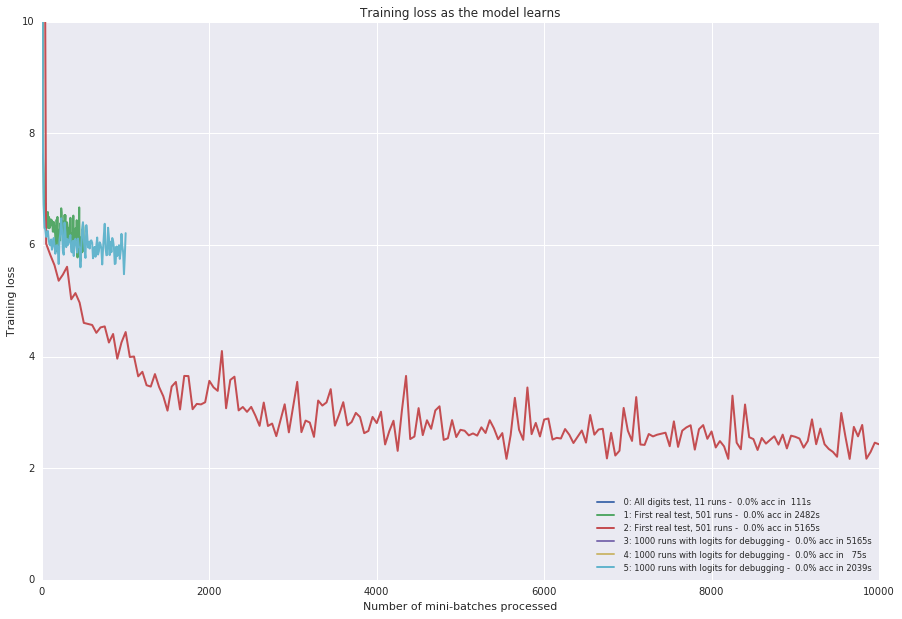

In [81]:
def smooth(x_input, y_input, steps):
  x_output, y_output = [],[]
  counter = 0
  for i in range(len(x_input)//steps):
    x_output.append(sum(x_input[counter:counter+steps]/steps))
    y_output.append(sum(y_input[counter:counter+steps]/steps))
    counter += steps
  return x_output, y_output
    
def plot_learning_chart(results_data, metric, smoothing, xlim, ylim, label_flag):
  metric_text = ['Step', 'Training loss', 'Test loss', 'Training accuracy', 'Test accuracy'][metric]
  fig, ax = plt.subplots(figsize=(15,10))
  fontP = FontProperties()
  fontP.set_size('small')
  for results in results_data: 
    i, params, long_text, learning_log, test_accuracy, run_time = results
    label = run_text_short(results) if params[-1] is not None and label_flag != "Full" else long_text 
    ax.plot(*smooth(learning_log[:,0], learning_log[:,metric],smoothing), label=label ,linewidth=2) 
  plt.title(metric_text+' as the model learns')
  plt.xlabel("Number of mini-batches processed")
  plt.ylabel(metric_text)
  if ylim is not None: plt.ylim(*ylim)
  if xlim is not None: plt.xlim(*xlim)
  ax.legend(loc=4,prop=fontP)
  plt.show()

plot_learning_chart(results_log, metric=1, smoothing=1, xlim=None, ylim=(0,10), label_flag = "")
# plot_learning_chart([results_log[n] for n in [51,52]], smoothing=1, xlim=None, ylim=(80,89), label_flag = "")
# to get the top 10 - 
# plot_learning_chart(sorted(results_log, key = lambda x: x[4])[-10:], smoothing=40, xlim=None, ylim=(75,85), label_flag = "Full")


In [82]:
### Print the results and if required, reshuffle to the latest structure ###
for n,results in enumerate(results_log): 
  i, params, full_text, learning_log, test_accuracy, run_time = results
  print(full_text)
#   print(learning_log[:3])
#   num_steps, batch_size, conv_layers, fully_connected_layers, \
#     initial_rate, learn_decay_rate, learn_decay_steps, weight_decay, momentum, dropout, nickname = params
#   params = (num_steps, batch_size, conv_layers, fully_connected_layers, \
#     initial_rate, learn_decay_rate, learn_decay_steps, weight_decay, momentum, dropout, nickname)
  
#  results_log[i]    = (i, params, full_text, learning_log, test_accuracy, run_time)

 0:     6x 8, [(5, 16, 2, 1, 1)]x2,  [64], 0.05 rt, 1.0 dcy,   1 st, W_d  0.1, mmtm None, d_o 1.0 -  0.0% acc in  111s
 1:   501x128, [(5, 32, 2, 2, 2)]x2, [512], 0.05 rt, 1.0 dcy,   1 st, W_d  0.1, mmtm None, d_o 1.0 -  0.0% acc in 2482s
 2: 10001x128, [(5, 16, 2, 2, 2), (5, 32, 2, 2, 2)], [1024], 0.05 rt, 1.0 dcy,   1 st, W_d  0.0, mmtm Adam, d_o 1.0 -  0.0% acc in 5165s
 3:     6x64, [(5, 16, 2, 2, 2), (5, 32, 2, 2, 2)], [1024], 0.05 rt, 1.0 dcy,   1 st, W_d  0.0, mmtm None, d_o 1.0 -  0.0% acc in 5165s
 4:     6x64, [(5, 16, 2, 2, 2), (5, 32, 2, 2, 2)], [1024], 0.05 rt, 1.0 dcy,   1 st, W_d  0.0, mmtm None, d_o 1.0 -  0.0% acc in   75s
 5:  1001x128, [(5, 16, 2, 2, 2), (5, 32, 2, 2, 2)], [1024], 0.05 rt, 1.0 dcy,   1 st, W_d  0.0, mmtm None, d_o 1.0 -  0.0% acc in 2039s


In [21]:
# save the results for later use

pickle_file = 'results.pickle'
os.environ['TZ'] = 'Europe/Zurich'
time.tzset()

try:
  f = open(pickle_file, 'wb')
  pickle.dump(results_log, f, pickle.HIGHEST_PROTOCOL)
  print("Done -",strftime("%H:%M"))
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

Done - 08:29


In [48]:
print(3)
a=3
print([a for a in range(10)])
print(a)

3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
9
